In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import spacy
from bs4 import BeautifulSoup

In [ ]:
# pandas display config
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 10000)

In [ ]:
def parse(path, limit):
    g = gzip.open(path, 'rb')
    for index, line in enumerate(g):
        if limit != 0 and index == limit:
            break
        yield eval(line)


def get_df(path, limit=0):
    i = 0
    df = {}
    for d in parse(path, limit):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
all_amazon_reviews_df = get_df('data/Datasets/reviews_Movies_and_TV_5.json.gz')[['overall', 'reviewText']]

In [ ]:
# amazon_reviews_df = all_amazon_reviews_df.sample(frac=0.3)

amazon_reviews_df = all_amazon_reviews_df

print('all_rows', all_amazon_reviews_df.shape)
print('amazon_reviews_df', amazon_reviews_df.shape)
amazon_reviews_df.rename(columns={'overall':'score', 'reviewText':'review'}, inplace=True)

In [ ]:
positive_reviews =  amazon_reviews_df[amazon_reviews_df.score > 4].reset_index(level=0, drop=True)
print('Positive Reviews: %d' % len(positive_reviews))

negative_reviews =  amazon_reviews_df[amazon_reviews_df.score < 2].reset_index(level=0, drop=True)
print('Negative Reviews: %d' % len(negative_reviews))

positive_reviews['label'] = 1
negative_reviews['label'] = 0

positive_reviews['clean_review'] = ''
negative_reviews['clean_review'] = ''

In [ ]:
positive_reviews.head()

In [ ]:
negative_reviews.head()

In [ ]:
print('Positive Reviews with null values: ', np.sum(positive_reviews.isnull().any(axis=1)))
print('Negative Reviews with null values: ', np.sum(negative_reviews.isnull().any(axis=1)))

print(positive_reviews.isnull().any(axis=0))
print(negative_reviews.isnull().any(axis=0))

In [77]:
nlp = spacy.load('en')

def cleanup_text(docs, logging=False):
    texts = []
#   counter = 1    
    
    for doc in tqdm(docs):        
#       if counter % 1000 == 0 and logging:
#            print("Processed %d out of %d documents." % (counter, len(docs)))
#       counter += 1
        
        # Remove html stuff
        doc = BeautifulSoup(doc, "lxml").text
        
        # disabling the parser improves performance
        doc_spacy = nlp(doc, disable=['parser', 'ner'])
        
        #Lemmatization (we shouldn't remove Stop-words since words like "very" would be removed)
        tokens = [
            tok.lemma_.lower().strip() for tok in doc_spacy 
            if tok.lemma_ != '-PRON-' 
            and tok.pos_ not in ('PUNCT', 'NUM', 'SYM')
#             and tok.pos_ != 'PART'      # This line seems to remove 's suffixes but also the NOT word in contractions like "I don't". It does not suit for sentiment analysis
        ]
        
        tokens = ' '.join(tokens)
        texts.append(tokens)
        
    return pd.Series(texts)


In [ ]:
pos_raw_reviews = positive_reviews.review.values.tolist()
pos_clean_reviews = cleanup_text(pos_raw_reviews, logging=True)

neg_raw_reviews = negative_reviews.review.values.tolist()
neg_clean_reviews = cleanup_text(neg_raw_reviews, logging=True)

positive_reviews['clean_review'] = pos_clean_reviews
negative_reviews['clean_review'] = neg_clean_reviews

positive_reviews.to_csv(r'amazon_positive_clean_reviews.csv')
negative_reviews.to_csv(r'amazon_negative_clean_reviews.csv')

In [2]:
positive_reviews = pd.read_csv('amazon_positive_clean_reviews.csv')
negative_reviews = pd.read_csv('amazon_negative_clean_reviews.csv')

In [3]:
print('Positive Reviews with null values: ', np.sum(positive_reviews.isnull().any(axis=1)))
print('Negative Reviews with null values: ', np.sum(negative_reviews.isnull().any(axis=1)))

print(positive_reviews.isnull().any(axis=0))
print(negative_reviews.isnull().any(axis=0))

Positive Reviews with null values:  38
Negative Reviews with null values:  4
Unnamed: 0      False
score           False
review           True
label           False
clean_review     True
dtype: bool
Unnamed: 0      False
score           False
review           True
label           False
clean_review     True
dtype: bool


In [4]:
positive_reviews = positive_reviews.dropna()
negative_reviews = negative_reviews.dropna()

In [5]:
print('Positive Reviews with null values: ', np.sum(positive_reviews.isnull().any(axis=1)))
print('Negative Reviews with null values: ', np.sum(negative_reviews.isnull().any(axis=1)))

print(positive_reviews.isnull().any(axis=0))
print(negative_reviews.isnull().any(axis=0))

Positive Reviews with null values:  0
Negative Reviews with null values:  0
Unnamed: 0      False
score           False
review          False
label           False
clean_review    False
dtype: bool
Unnamed: 0      False
score           False
review          False
label           False
clean_review    False
dtype: bool


In [8]:
print(positive_reviews.shape)
print(len(negative_reviews))

(906570, 5)
104215


In [9]:
pos_rev_sample = positive_reviews.sample(n = len(negative_reviews))

In [11]:
pos_rev_sample.shape
pos_rev_sample.head()

,Unnamed: 0,score,review,label,clean_review
303783,303783,5.0,This was the first Miyazaki film that I watche...,1,this be the first miyazaki film that watch and...
20149,20149,5.0,This film is a master piece! I will not preten...,1,this film be a master piece will not pretend t...
191454,191454,5.0,This is THE definitive movie on Alien Abductio...,1,this be the definitive movie on alien abductio...
366276,366276,5.0,"Good Flic, adds to my series. I hope to see a...",1,good flic add to series hope to see another o...
518186,518186,5.0,This is a great movie. Specially since it is a...,1,this be a great movie specially since be a tru...


In [12]:
from sklearn.model_selection import train_test_split

#use 1 for positive sentiment, 0 for negative
y = np.concatenate((np.ones(len(pos_rev_sample.review)), np.zeros(len(negative_reviews.review))))
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_rev_sample.clean_review, negative_reviews.clean_review)), y, test_size=0.3)

In [13]:
from gensim.utils import save_as_line_sentence

all_samples = np.concatenate((x_train, x_test))

sentences = [s.split() for (idx, s) in enumerate(tqdm(all_samples))]

print(len(x_train))
print(len(x_test))
print(len(all_samples))
print(len(sentences))

save_as_line_sentence(sentences, 'all_samples_sentences.txt')
print('sentences saved')


145901
62529
208430
208430
sentences saved


In [36]:
x_train[145900]

'this be a nice boxed set the additional making of disc be also very interesting if can get cheap enough get it these movie do not hold up as masterpiece but be all fun to watch on a rainy sunday afternoon if be like will get an abrupt urge to watch raiders and be shocked to find be not available on netflix nor do have a copy of now that have the whole set this will not happen again!"crystal skull be not include but be not really in the same class as the original movie'

In [38]:
x_test[0]

'tis be a overrated movie ,incomprehensible that this long boring movie be even nominate for a oscar award maybe miss something'

In [39]:
all_samples[145900]

'this be a nice boxed set the additional making of disc be also very interesting if can get cheap enough get it these movie do not hold up as masterpiece but be all fun to watch on a rainy sunday afternoon if be like will get an abrupt urge to watch raiders and be shocked to find be not available on netflix nor do have a copy of now that have the whole set this will not happen again!"crystal skull be not include but be not really in the same class as the original movie'

In [40]:
all_samples[145901]

'tis be a overrated movie ,incomprehensible that this long boring movie be even nominate for a oscar award maybe miss something'

In [ ]:
from_train_

In [15]:
# from gensim.models.doc2vec import TaggedDocument

# xtrain_tagged = [TaggedDocument(words=s.split(' '), tags=['train_sample_%d' % idx]) for (idx, s) in enumerate(tqdm(x_train))]  
# xtest_tagged = [TaggedDocument(words=s.split(' '), tags=['test_sample_%d' % idx]) for (idx, s) in enumerate(tqdm(x_test))]

In [17]:
from gensim.models.doc2vec import Doc2Vec
import multiprocessing
from sklearn import utils
import time



corpus_file = "all_samples_sentences.txt"
vector_size = 300
min_count = 5
window = 6
sample = 1e-3
negative = 5
cores = multiprocessing.cpu_count()
epochs = 10
# all_tagged = xtrain_tagged + xtest_tagged


start_time = time.time()

model_dmc = Doc2Vec(
    corpus_file=corpus_file, 
    dm=1,
    dm_concat=1,
    vector_size=vector_size, 
    min_count=min_count, 
    window=window, 
    sample=sample, 
    negative=negative,
    workers=cores, 
    epochs=epochs)

model_dmc.save('d2v_model_dmc.model')

file_time = time.time() - start_time

# model_dmc.build_vocab(all_tagged)
# model_dmc.train(utils.shuffle([x for x in tqdm(all_tagged)]), total_examples=len(all_tagged), epochs=10)

print("Training model with `corpus_file` took {:.3f} seconds".format(file_time))

Training model with `corpus_file` took 1078.623 seconds


In [18]:
start_time = time.time()

model_dmm = Doc2Vec(
    corpus_file=corpus_file, 
    dm=1,
    dm_mean=1,
    vector_size=vector_size, 
    min_count=min_count, 
    window=window, 
    sample=sample, 
    negative=negative,
    workers=cores, 
    epochs=epochs)

model_dmm.save('d2v_model_dmm.model')

file_time = time.time() - start_time

# model_dmc.build_vocab(all_tagged)
# model_dmc.train(utils.shuffle([x for x in tqdm(all_tagged)]), total_examples=len(all_tagged), epochs=10)

print("Training model with `corpus_file` took {:.3f} seconds".format(file_time))

Training model with `corpus_file` took 152.728 seconds


In [19]:
start_time = time.time()

model_dbow = Doc2Vec(
    corpus_file=corpus_file, 
    dm=0,
    vector_size=vector_size, 
    min_count=min_count, 
    window=window, 
    sample=sample, 
    negative=negative,
    workers=cores, 
    epochs=epochs)

model_dbow.save('d2v_model_dbow.model')

file_time = time.time() - start_time

# model_dmc.build_vocab(all_tagged)
# model_dmc.train(utils.shuffle([x for x in tqdm(all_tagged)]), total_examples=len(all_tagged), epochs=10)

print("Training model with `corpus_file` took {:.3f} seconds".format(file_time))

Training model with `corpus_file` took 97.303 seconds


In [ ]:
"""model_dmm = gensim.models.Doc2Vec(min_count=2, window=10, vector_size=vsize, sample=1e-3, negative=5, workers=cores, dm=1, dm_mean = 1)
model_dmm.build_vocab(all_tagged)
model_dmm.train(utils.shuffle([x for x in tqdm(all_tagged)]), total_examples=len(all_tagged), epochs=10)
model_dmm.save('d2v_model_dmm.model')"""

In [ ]:
"""model_dbow = gensim.models.Doc2Vec(min_count=2, window=10, vector_size=vsize, sample=1e-3, negative=5, dm=0, workers=cores)
model_dbow.build_vocab(all_tagged)
model_dbow.train(utils.shuffle([x for x in tqdm(all_tagged)]), total_examples=len(all_tagged), epochs=10)
model_dbow.save('d2v_model_dbow.model')"""

In [20]:
print('model_dmm - great')
print(model_dmm.wv.most_similar('great'))
print("")
print('model_dmm - terrible')
print(model_dmm.wv.most_similar('terrible'))
print("")
print('model_dmc - great')
print(model_dmc.wv.most_similar('great'))
print("")
print('model_dmc - terrible')
print(model_dmc.wv.most_similar('terrible'))
print("")
print('model_dbow - great')
print(model_dbow.wv.most_similar('great'))
print("")
print('model_dbow - terrible')
print(model_dbow.wv.most_similar('terrible'))

model_dmm - great
[('wonderful', 0.6091040372848511), ('terrific', 0.5842635035514832), ('fantastic', 0.5745903253555298), ('good', 0.5738908648490906), ('excellent', 0.4968976080417633), ('fine', 0.4762903153896332), ('wonderfull', 0.4691181778907776), ('amazing', 0.4620956778526306), ('superb', 0.4560147225856781), ('tremendous', 0.4501250088214874)]

model_dmm - terrible
[('horrible', 0.7767344117164612), ('atrocious', 0.6128928065299988), ('awful', 0.5858620405197144), ('horrendous', 0.5743417739868164), ('dreadful', 0.5465333461761475), ('horrid', 0.5401270389556885), ('bad', 0.5034276247024536), ('lousy', 0.49029532074928284), ('abysmal', 0.47262728214263916), ('subpar', 0.4548766613006592)]

model_dmc - great
[('fantastic', 0.6538336277008057), ('wonderful', 0.6264678239822388), ('terrific', 0.6162378787994385), ('excellent', 0.5706093311309814), ('gret', 0.564849853515625), ('good', 0.5384150743484497), ('tremendous', 0.523584246635437), ('agreat', 0.5232450366020203), ('teriff

In [22]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_dbow_dmm = ConcatenatedDoc2Vec([model_dbow, model_dmm])
model_dbow_dmc = ConcatenatedDoc2Vec([model_dbow, model_dmc])

In [ ]:
from gensim.test.utils import datapath

model_dmm_accuracy = model_dmm.wv.evaluate_word_analogies(datapath('questions-words.txt'))[0]
print("Word analogy accuracy with `sentences`: {:.1f}%".format(100.0 * model_sent_accuracy))

model_corp_file_accuracy = model_corp_file.wv.evaluate_word_analogies(datapath('questions-words.txt'))[0]
print("Word analogy accuracy with `corpus_file`: {:.1f}%".format(100.0 * model_corp_file_accuracy))

In [41]:
from gensim.models.doc2vec import TaggedDocument

xtrain_tagged = [TaggedDocument(words=s.split(' '), tags=[idx]) for (idx, s) in enumerate(tqdm(x_train))]  
xtest_tagged = [TaggedDocument(words=s.split(' '), tags=[145901 +  idx]) for (idx, s) in enumerate(tqdm(x_test))]

In [34]:
from gensim.models.doc2vec import TaggedLineDocument

all_tagged = [s for s in TaggedLineDocument(corpus_file)]

In [42]:
all_tagged[10]

TaggedDocument(words=['this', 'movie', 'be', 'about', 'a', 'daughter', 'return', 'home', 'for', 'christmas', 'and', 'find', 'out', 'that', 'the', 'place', 'grow', 'up', 'know', 'as', 'santa', 'ville', 'be', 'in', 'big', 'trouble', 'and', 'have', 'to', 'find', 'a', 'way', 'to', 'save', 'so', 'start', 'out', 'to', 'save', 'and', 'have', 'alot', 'of', 'problem', 'along', 'the', 'way', 'but', 'find', 'love', 'and', 'home', 'along', 'the', 'way'], tags=[10])

In [43]:
xtrain_tagged[10]

TaggedDocument(words=['this', 'movie', 'be', 'about', 'a', 'daughter', 'return', 'home', 'for', 'christmas', 'and', 'find', 'out', 'that', 'the', 'place', 'grow', 'up', 'know', 'as', 'santa', 'ville', 'be', 'in', 'big', 'trouble', 'and', 'have', 'to', 'find', 'a', 'way', 'to', 'save', '', 'so', 'start', 'out', 'to', 'save', 'and', 'have', 'alot', 'of', 'problem', 'along', 'the', 'way', 'but', 'find', 'love', 'and', 'home', 'along', 'the', 'way'], tags=[10])

In [51]:
xtest_tagged[10]

TaggedDocument(words=['i', 'order', 'this', 'movie', '', 'for', 'good', 'friend', '', 'but', 'i', 'love', 'too', 'so', 'i', 'buy', 'one', 'to', 'thank'], tags=[145911])

In [50]:
all_tagged[145901 + 10]

TaggedDocument(words=['i', 'order', 'this', 'movie', 'for', 'good', 'friend', 'but', 'i', 'love', 'too', 'so', 'i', 'buy', 'one', 'to', 'thank'], tags=[145911])

In [55]:
#Get training set vectors from our models
def getVecs(model, tagged_docs):
    vecs = [model.infer_vector(doc.words, steps=epochs) for doc in tqdm(tagged_docs)]
    return vecs

train_vecs_dmm = getVecs(model_dmm, xtrain_tagged)
train_vecs_dmc = getVecs(model_dmc, xtrain_tagged)
train_vecs_dbow = getVecs(model_dbow, xtrain_tagged)
train_vecs_dbow_dmm = getVecs(model_dbow_dmm, xtrain_tagged)
train_vecs_dbow_dmc = getVecs(model_dbow_dmc, xtrain_tagged)

In [58]:
test_vecs_dmm = getVecs(model_dmm, xtest_tagged)
test_vecs_dmc = getVecs(model_dmc, xtest_tagged)
test_vecs_dbow = getVecs(model_dbow, xtest_tagged)
test_vecs_dbow_dmm = getVecs(model_dbow_dmm, xtest_tagged)
test_vecs_dbow_dmc = getVecs(model_dbow_dmc, xtest_tagged)

In [59]:
from keras.models import Sequential
from keras import layers

np_train_vecs_dmm = np.array(train_vecs_dmm)
np_test_vecs_dmm = np.array(test_vecs_dmm)

np_train_vecs_dmc = np.array(train_vecs_dmc)
np_test_vecs_dmc = np.array(test_vecs_dmc)

np_train_vecs_dbow = np.array(train_vecs_dbow)
np_test_vecs_dbow = np.array(test_vecs_dbow)

np_train_vecs_dbow_dmm = np.array(train_vecs_dbow_dmm)
np_test_vecs_dbow_dmm = np.array(test_vecs_dbow_dmm)

np_train_vecs_dbow_dmc = np.array(train_vecs_dbow_dmc)
np_test_vecs_dbow_dmc = np.array(test_vecs_dbow_dmc)

np_y_train = np.array(y_train)
np_y_test = np.array(y_test)

np_train_vecs_dmm.shape


(145901, 300)

In [145]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history, model_title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy - %s' % model_title)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss - %s' % model_title)
    plt.legend()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________
Train on 145901 samples, validate on 62529 samples
Epoch 1/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.7070 - accuracy: 0.5082 - val_loss: 0.7000 - val_accuracy: 0.5160
Epoch 2/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.6985 - accuracy: 0.5202 - val_loss: 0.6925 - val_accuracy: 0.5331
Epoch 3/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.6911 - accuracy: 0.5381 - val_loss: 0.6858 - val_accuracy: 0.5544
Epoch 4/100
145

145901/145901 [==============================] - 0s 2us/step - loss: 0.4412 - accuracy: 0.8091 - val_loss: 0.4424 - val_accuracy: 0.8074
Epoch 52/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.4397 - accuracy: 0.8098 - val_loss: 0.4410 - val_accuracy: 0.8077
Epoch 53/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.4381 - accuracy: 0.8101 - val_loss: 0.4395 - val_accuracy: 0.8081
Epoch 54/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.4367 - accuracy: 0.8105 - val_loss: 0.4382 - val_accuracy: 0.8085
Epoch 55/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.4353 - accuracy: 0.8110 - val_loss: 0.4368 - val_accuracy: 0.8091
Epoch 56/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.4340 - accuracy: 0.8114 - val_loss: 0.4356 - val_accuracy: 0.8095
Epoch 57/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.4327 - accuracy: 0.8119 - val

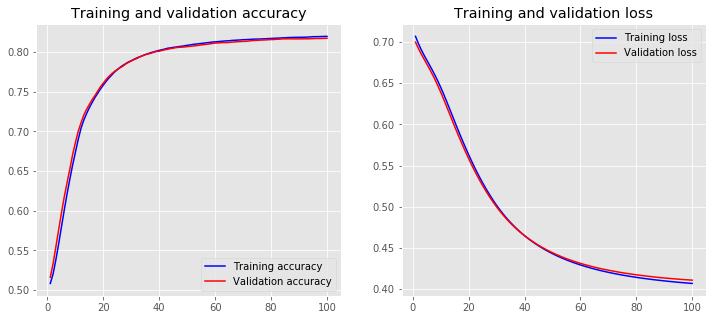

In [122]:
input_dim_dmm = np_train_vecs_dmm.shape[1]  # Number of features

k_model_dmm = Sequential()
k_model_dmm.add(layers.Dense(10, input_dim=input_dim_dmm, activation='relu'))
k_model_dmm.add(layers.Dense(1, activation='sigmoid'))
k_model_dmm.compile(loss='binary_crossentropy', 
               optimizer='adam', 
      metrics=['accuracy'])
k_model_dmm.summary()

history_dmm = k_model_dmm.fit(np_train_vecs_dmm, np_y_train,
                     epochs=100,                    
                     verbose=True,
                     validation_data=(np_test_vecs_dmm, np_y_test),
                     batch_size=100000)

dmm_train_loss, dmm_train_accuracy = k_model_dmm.evaluate(np_train_vecs_dmm, np.array(np_y_train), verbose=False)
print("Training Accuracy DMM: {:.4f}".format(dmm_train_accuracy))
dmm_test_loss, dmm_test_accuracy = k_model_dmm.evaluate(np.array(np_test_vecs_dmm), np.array(np_y_test), verbose=False)
print("Testing Accuracy DMM:  {:.4f}".format(dmm_test_accuracy))

plot_history(history_dmm, 'DMM')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________
Train on 145901 samples, validate on 62529 samples
Epoch 1/100
145901/145901 [==============================] - 1s 5us/step - loss: 0.6936 - accuracy: 0.5104 - val_loss: 0.6915 - val_accuracy: 0.5302
Epoch 2/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.6914 - accuracy: 0.5287 - val_loss: 0.6894 - val_accuracy: 0.5471
Epoch 3/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.6893 - accuracy: 0.5456 - val_loss: 0.6874 - val_accuracy: 0.5637
Epoch 4/100
145

145901/145901 [==============================] - 0s 2us/step - loss: 0.5644 - accuracy: 0.7444 - val_loss: 0.5660 - val_accuracy: 0.7420
Epoch 52/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.5624 - accuracy: 0.7450 - val_loss: 0.5640 - val_accuracy: 0.7428
Epoch 53/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.5604 - accuracy: 0.7454 - val_loss: 0.5622 - val_accuracy: 0.7433
Epoch 54/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.5585 - accuracy: 0.7458 - val_loss: 0.5603 - val_accuracy: 0.7437
Epoch 55/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.5566 - accuracy: 0.7461 - val_loss: 0.5585 - val_accuracy: 0.7442
Epoch 56/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.5548 - accuracy: 0.7462 - val_loss: 0.5568 - val_accuracy: 0.7446
Epoch 57/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.5530 - accuracy: 0.7466 - val

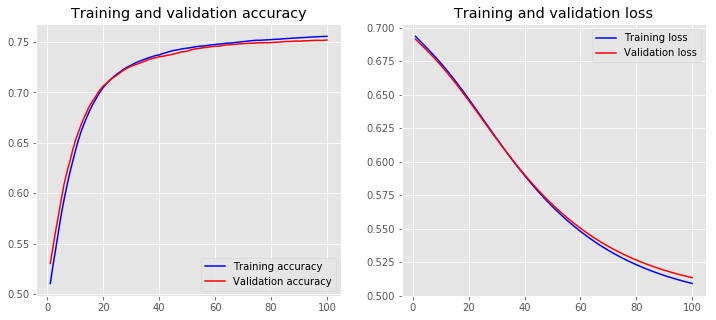

In [120]:
input_dim_dmc = np_train_vecs_dmc.shape[1]  # Number of features

k_model_dmc = Sequential()
k_model_dmc.add(layers.Dense(10, input_dim=input_dim_dmc, activation='relu'))
k_model_dmc.add(layers.Dense(1, activation='sigmoid'))
k_model_dmc.compile(loss='binary_crossentropy', 
               optimizer='adam', 
      metrics=['accuracy'])
k_model_dmc.summary()

history_dmc = k_model_dmc.fit(np_train_vecs_dmc, np_y_train,
                     epochs=100,                    
                     verbose=True,
                     validation_data=(np_test_vecs_dmc, np_y_test),
                     batch_size=100000)

plot_history(history_dmc, 'DMC')

dmc_train_loss, dmc_train_accuracy = k_model_dmc.evaluate(np_train_vecs_dmc, np.array(np_y_train), verbose=False)
print("Training Accuracy DMC: {:.4f}".format(dmc_train_accuracy))
dmc_test_loss, dmc_test_accuracy = k_model_dmc.evaluate(np.array(np_test_vecs_dmc), np.array(np_y_test), verbose=False)
print("Testing Accuracy DMC:  {:.4f}".format(dmc_test_accuracy))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________
Train on 145901 samples, validate on 62529 samples
Epoch 1/100
145901/145901 [==============================] - 1s 3us/step - loss: 0.6984 - accuracy: 0.4908 - val_loss: 0.6928 - val_accuracy: 0.5038
Epoch 2/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.6923 - accuracy: 0.5041 - val_loss: 0.6872 - val_accuracy: 0.5191
Epoch 3/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.6867 - accuracy: 0.5200 - val_loss: 0.6819 - val_accuracy: 0.5388
Epoch 4/100
145

145901/145901 [==============================] - 0s 2us/step - loss: 0.3412 - accuracy: 0.8881 - val_loss: 0.3371 - val_accuracy: 0.8892
Epoch 52/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.3378 - accuracy: 0.8888 - val_loss: 0.3338 - val_accuracy: 0.8898
Epoch 53/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.3345 - accuracy: 0.8893 - val_loss: 0.3306 - val_accuracy: 0.8905
Epoch 54/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.3313 - accuracy: 0.8898 - val_loss: 0.3275 - val_accuracy: 0.8913
Epoch 55/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.3283 - accuracy: 0.8903 - val_loss: 0.3245 - val_accuracy: 0.8917
Epoch 56/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.3253 - accuracy: 0.8908 - val_loss: 0.3217 - val_accuracy: 0.8919
Epoch 57/100
145901/145901 [==============================] - 0s 2us/step - loss: 0.3225 - accuracy: 0.8913 - val

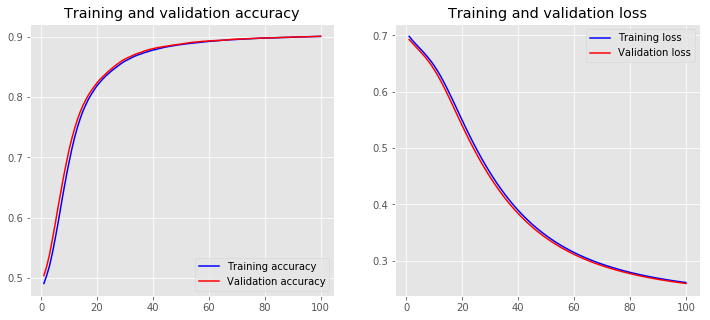

In [123]:
input_dim_dbow = np_train_vecs_dbow.shape[1]  # Number of features

k_model_dbow = Sequential()
k_model_dbow.add(layers.Dense(10, input_dim=input_dim_dbow, activation='relu'))
k_model_dbow.add(layers.Dense(1, activation='sigmoid'))
k_model_dbow.compile(loss='binary_crossentropy', 
               optimizer='adam', 
      metrics=['accuracy'])
k_model_dbow.summary()

history_dbow = k_model_dbow.fit(np_train_vecs_dbow, np_y_train,
                     epochs=100,                    
                     verbose=True,
                     validation_data=(np_test_vecs_dbow, np_y_test),
                     batch_size=100000)

plot_history(history_dbow, 'DBOW')

dbow_train_loss, dbow_train_accuracy = k_model_dbow.evaluate(np_train_vecs_dbow, np.array(np_y_train), verbose=False)
print("Training Accuracy DBOW: {:.4f}".format(dbow_train_accuracy))
dbow_test_loss, dbow_test_accuracy = k_model_dbow.evaluate(np.array(np_test_vecs_dbow), np.array(np_y_test), verbose=False)
print("Testing Accuracy DBOW:  {:.4f}".format(dbow_test_accuracy))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________
Train on 145901 samples, validate on 62529 samples
Epoch 1/100
145901/145901 [==============================] - 1s 5us/step - loss: 0.6936 - accuracy: 0.5112 - val_loss: 0.6870 - val_accuracy: 0.5566
Epoch 2/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.6861 - accuracy: 0.5623 - val_loss: 0.6796 - val_accuracy: 0.6055
Epoch 3/100
145901/145901 [==============================] - 1s 3us/step - loss: 0.6786 - accuracy: 0.6088 - val_loss: 0.6722 - val_accuracy: 0.6456
Epoch 4/100
145

145901/145901 [==============================] - 0s 3us/step - loss: 0.3277 - accuracy: 0.8933 - val_loss: 0.3255 - val_accuracy: 0.8935
Epoch 52/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.3247 - accuracy: 0.8937 - val_loss: 0.3226 - val_accuracy: 0.8937
Epoch 53/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.3218 - accuracy: 0.8940 - val_loss: 0.3198 - val_accuracy: 0.8941
Epoch 54/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.3191 - accuracy: 0.8945 - val_loss: 0.3171 - val_accuracy: 0.8944
Epoch 55/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.3164 - accuracy: 0.8947 - val_loss: 0.3146 - val_accuracy: 0.8947
Epoch 56/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.3139 - accuracy: 0.8949 - val_loss: 0.3121 - val_accuracy: 0.8949
Epoch 57/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.3114 - accuracy: 0.8953 - val

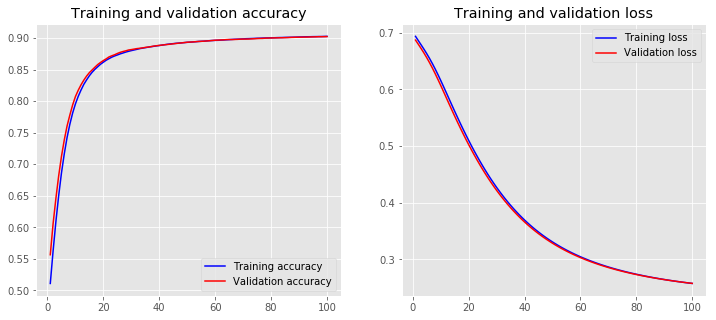

In [125]:
input_dim_dbow_dmc = np_train_vecs_dbow_dmc.shape[1]  # Number of features

k_model_dbow_dmc = Sequential()
k_model_dbow_dmc.add(layers.Dense(10, input_dim=input_dim_dbow_dmc, activation='relu'))
k_model_dbow_dmc.add(layers.Dense(1, activation='sigmoid'))
k_model_dbow_dmc.compile(loss='binary_crossentropy', 
               optimizer='adam', 
      metrics=['accuracy'])
k_model_dmc.summary()

history_dbow_dmc = k_model_dbow_dmc.fit(np_train_vecs_dbow_dmc, np_y_train,
                     epochs=100,                    
                     verbose=True,
                     validation_data=(np_test_vecs_dbow_dmc, np_y_test),
                     batch_size=100000)

plot_history(history_dbow_dmc, 'DBOW+DMC')

dbow_dmc_train_loss, dbow_dmc_train_accuracy = k_model_dbow_dmc.evaluate(np_train_vecs_dbow_dmc, np.array(np_y_train), verbose=False)
print("Training Accuracy DBOW+DMC: {:.4f}".format(dbow_dmc_train_accuracy))
dbow_dmc_test_loss, dbow_dmc_test_accuracy = k_model_dbow_dmc.evaluate(np.array(np_test_vecs_dbow_dmc), np.array(np_y_test), verbose=False)
print("Testing Accuracy DBOW+DMC:  {:.4f}".format(dbow_dmc_test_accuracy))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 10)                6010      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 6,021
Trainable params: 6,021
Non-trainable params: 0
_________________________________________________________________
Train on 145901 samples, validate on 62529 samples
Epoch 1/100
145901/145901 [==============================] - 1s 6us/step - loss: 0.7124 - accuracy: 0.4954 - val_loss: 0.6985 - val_accuracy: 0.5152
Epoch 2/100
145901/145901 [==============================] - 1s 3us/step - loss: 0.6957 - accuracy: 0.5239 - val_loss: 0.6839 - val_accuracy: 0.5624
Epoch 3/100
145901/145901 [==============================] - 1s 4us/step - loss: 0.6813 - accuracy: 0.5737 - val_loss: 0.6706 - val_accuracy: 0.6173
Epoch 4/100
145

145901/145901 [==============================] - 0s 3us/step - loss: 0.2830 - accuracy: 0.8986 - val_loss: 0.2836 - val_accuracy: 0.8962
Epoch 52/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.2813 - accuracy: 0.8989 - val_loss: 0.2820 - val_accuracy: 0.8964
Epoch 53/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.2797 - accuracy: 0.8992 - val_loss: 0.2805 - val_accuracy: 0.8967
Epoch 54/100
145901/145901 [==============================] - 1s 3us/step - loss: 0.2782 - accuracy: 0.8995 - val_loss: 0.2790 - val_accuracy: 0.8970
Epoch 55/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.2768 - accuracy: 0.8997 - val_loss: 0.2777 - val_accuracy: 0.8974
Epoch 56/100
145901/145901 [==============================] - 1s 3us/step - loss: 0.2753 - accuracy: 0.9001 - val_loss: 0.2763 - val_accuracy: 0.8977
Epoch 57/100
145901/145901 [==============================] - 0s 3us/step - loss: 0.2740 - accuracy: 0.9003 - val

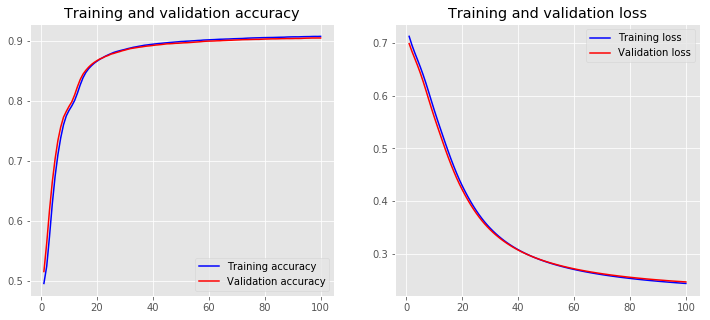

In [126]:
input_dim_dbow_dmm = np_train_vecs_dbow_dmm.shape[1]  # Number of features

k_model_dbow_dmm = Sequential()
k_model_dbow_dmm.add(layers.Dense(10, input_dim=input_dim_dbow_dmm, activation='relu'))
k_model_dbow_dmm.add(layers.Dense(1, activation='sigmoid'))
k_model_dbow_dmm.compile(loss='binary_crossentropy', 
               optimizer='adam', 
      metrics=['accuracy'])
k_model_dbow_dmm.summary()

history_dbow_dmm = k_model_dbow_dmm.fit(np_train_vecs_dbow_dmm, np_y_train,
                     epochs=100,                    
                     verbose=True,
                     validation_data=(np_test_vecs_dbow_dmm, np_y_test),
                     batch_size=100000)

plot_history(history_dbow_dmm, 'DBOW+DMM')

dbow_dmm_train_loss, dbow_dmm_train_accuracy = k_model_dbow_dmm.evaluate(np_train_vecs_dbow_dmm, np.array(np_y_train), verbose=False)
print("Training Accuracy DBOW+DMM: {:.4f}".format(dbow_dmc_train_accuracy))
dbow_dmm_test_loss, dbow_dmm_test_accuracy = k_model_dbow_dmm.evaluate(np.array(np_test_vecs_dbow_dmm), np.array(np_y_test), verbose=False)
print("Testing Accuracy DBOW+DMM:  {:.4f}".format(dbow_dmm_test_accuracy))

In [127]:
dmm_train_loss, dmm_train_accuracy = k_model_dmm.evaluate(np_train_vecs_dmm, np.array(np_y_train), verbose=False)
print("Training Accuracy DMM: {:.4f}".format(dmm_train_accuracy))
dmm_test_loss, dmm_test_accuracy = k_model_dmm.evaluate(np.array(np_test_vecs_dmm), np.array(np_y_test), verbose=False)
print("Testing Accuracy DMM:  {:.4f}".format(dmm_test_accuracy))
dmc_train_loss, dmc_train_accuracy = k_model_dmc.evaluate(np_train_vecs_dmc, np.array(np_y_train), verbose=False)
print("Training Accuracy DMC: {:.4f}".format(dmc_train_accuracy))
dmc_test_loss, dmc_test_accuracy = k_model_dmc.evaluate(np.array(np_test_vecs_dmc), np.array(np_y_test), verbose=False)
print("Testing Accuracy DMC:  {:.4f}".format(dmc_test_accuracy))
dbow_train_loss, dbow_train_accuracy = k_model_dbow.evaluate(np_train_vecs_dbow, np.array(np_y_train), verbose=False)
print("Training Accuracy DBOW: {:.4f}".format(dbow_train_accuracy))
dbow_test_loss, dbow_test_accuracy = k_model_dbow.evaluate(np.array(np_test_vecs_dbow), np.array(np_y_test), verbose=False)
print("Testing Accuracy DBOW:  {:.4f}".format(dbow_test_accuracy))
dbow_dmc_train_loss, dbow_dmc_train_accuracy = k_model_dbow_dmc.evaluate(np_train_vecs_dbow_dmc, np.array(np_y_train), verbose=False)
print("Training Accuracy DBOW+DMC: {:.4f}".format(dbow_dmc_train_accuracy))
dbow_dmc_test_loss, dbow_dmc_test_accuracy = k_model_dbow_dmc.evaluate(np.array(np_test_vecs_dbow_dmc), np.array(np_y_test), verbose=False)
print("Testing Accuracy DBOW+DMC:  {:.4f}".format(dbow_dmc_test_accuracy))
dbow_dmm_train_loss, dbow_dmm_train_accuracy = k_model_dbow_dmm.evaluate(np_train_vecs_dbow_dmm, np.array(np_y_train), verbose=False)
print("Training Accuracy DBOW+DMM: {:.4f}".format(dbow_dmc_train_accuracy))
dbow_dmm_test_loss, dbow_dmm_test_accuracy = k_model_dbow_dmm.evaluate(np.array(np_test_vecs_dbow_dmm), np.array(np_y_test), verbose=False)
print("Testing Accuracy DBOW+DMM:  {:.4f}".format(dbow_dmm_test_accuracy))


Training Accuracy DMM: 0.8199
Testing Accuracy DMM:  0.8175
Training Accuracy DMC: 0.7559
Testing Accuracy DMC:  0.7521
Training Accuracy DBOW: 0.9013
Testing Accuracy DBOW:  0.9012
Training Accuracy DBOW+DMC: 0.9027
Testing Accuracy DBOW+DMC:  0.9022
Training Accuracy DBOW+DMM: 0.9027
Testing Accuracy DBOW+DMM:  0.9043


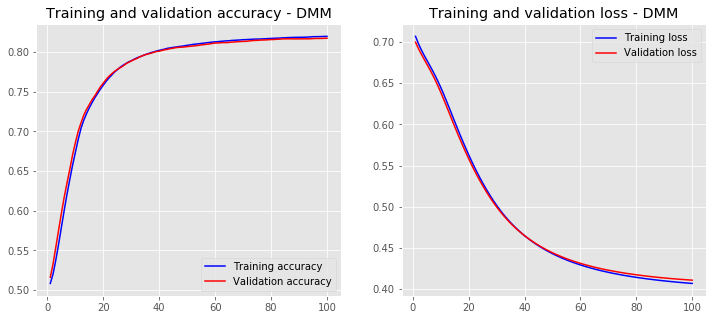

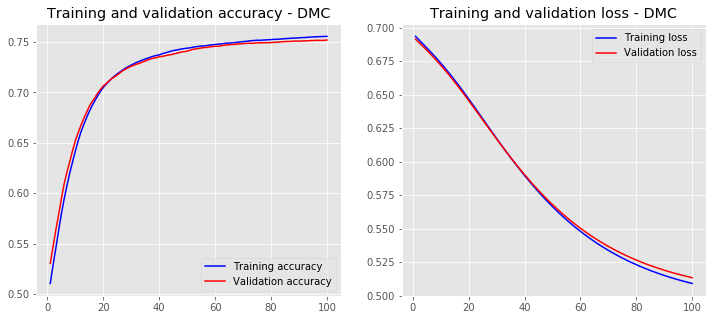

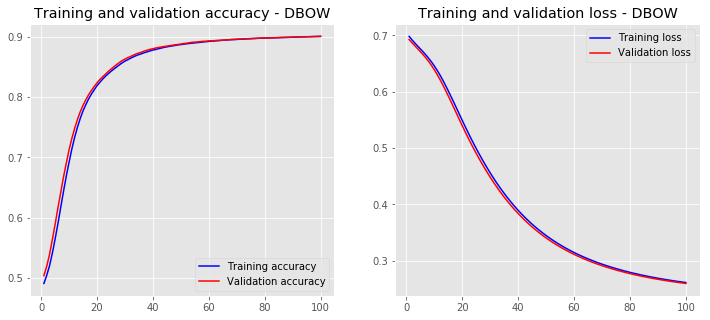

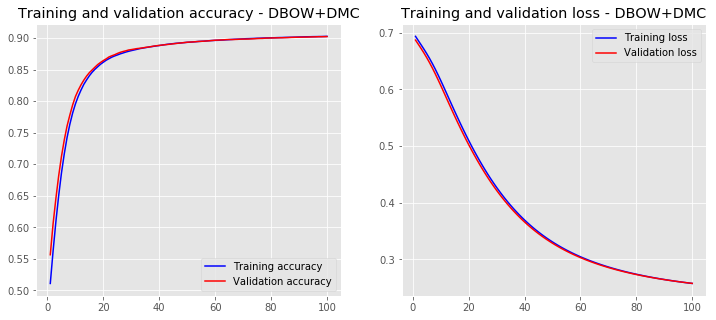

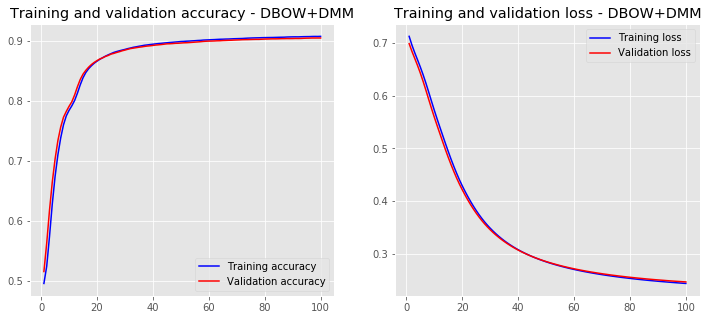

In [146]:
plot_history(history_dmm, 'DMM')
plot_history(history_dmc, 'DMC')
plot_history(history_dbow, 'DBOW')
plot_history(history_dbow_dmc, 'DBOW+DMC')
plot_history(history_dbow_dmm, 'DBOW+DMM')


In [128]:
pos_sentence = ["This is a really great and very cool movie"]
clean_pos_s = [s.split() for s in cleanText(pos_sentence)]
clean_pos_s = clean_pos_s[0]
print('clean_pos_s: ', clean_pos_s)

print(model_dmm.most_similar('great'))

pos_v = model_dmm.infer_vector(clean_pos_s)
pos_v = np.array([pos_v])

pos_pred = k_model_dmm.predict(pos_v)

print('Positive prediction?: ', pos_pred)

neg_sentence = ["This is a terrible movie. A very bad movie, I hate it. I don't like it"]
clean_neg_s = [s.split() for s in cleanText(neg_sentence)]
clean_neg_s = clean_neg_s[0]
print('clean_pos_s: ', clean_neg_s)

print(model_dmm.most_similar('terrible'))

neg_v = model_dmm.infer_vector(clean_neg_s)
neg_v = np.array([neg_v])

neg_pred = k_model_dmm.predict(neg_v)

print('Negative prediction?: ', neg_pred)


clean_pos_s:  ['this', 'be', 'a', 'really', 'great', 'and', 'very', 'cool', 'movie']
[('wonderful', 0.6091040372848511), ('terrific', 0.5842635035514832), ('fantastic', 0.5745903253555298), ('good', 0.5738908648490906), ('excellent', 0.4968976080417633), ('fine', 0.4762903153896332), ('wonderfull', 0.4691181778907776), ('amazing', 0.4620956778526306), ('superb', 0.4560147225856781), ('tremendous', 0.4501250088214874)]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


Positive prediction?:  [[0.76487017]]



clean_pos_s:  ['this', 'be', 'a', 'terrible', 'movie', 'a', 'very', 'bad', 'movie', 'hate', 'do', 'not', 'like']
[('horrible', 0.7767344117164612), ('atrocious', 0.6128928065299988), ('awful', 0.5858620405197144), ('horrendous', 0.5743417739868164), ('dreadful', 0.5465333461761475), ('horrid', 0.5401270389556885), ('bad', 0.5034276247024536), ('lousy', 0.49029532074928284), ('abysmal', 0.47262728214263916), ('subpar', 0.4548766613006592)]
Negative prediction?:  [[0.2610477]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


In [130]:
pos_sentence = ["This is a really great and very cool movie"]

clean_pos_s = [s.split() for s in cleanText(pos_sentence)]
clean_pos_s = clean_pos_s[0]
print('clean_pos_s: ', clean_pos_s)

print('MODEL DMM MOST SIMILAR TO GREAT', model_dmm.most_similar('great'))
print('MODEL DMC MOST SIMILAR TO GREAT', model_dmc.most_similar('great'))
print('MODEL DBOW MOST SIMILAR TO GREAT', model_dbow.most_similar('great')) # dbow doesn't preserve word vectors 
# concatenated models don't have most_similar option

pos_v_dmm = np.array([model_dmm.infer_vector(clean_pos_s)])
pos_v_dmc = np.array([model_dmc.infer_vector(clean_pos_s)])
pos_v_dbow = np.array([model_dbow.infer_vector(clean_pos_s)])
pos_v_dbow_dmm = np.array([model_dbow_dmm.infer_vector(clean_pos_s)])
pos_v_dbow_dmc = np.array([model_dbow_dmc.infer_vector(clean_pos_s)])

pos_pred_dmm = k_model_dmm.predict(pos_v_dmm)
print('DMM Positive prediction: ', pos_pred_dmm)
pos_pred_dmc = k_model_dmc.predict(pos_v_dmc)
print('DMC Positive prediction: ', pos_pred_dmc)
pos_pred_dbow = k_model_dbow.predict(pos_v_dbow)
print('DBOW Positive prediction: ', pos_pred_dbow)
pos_pred_dbow_dmm = k_model_dbow_dmm.predict(pos_v_dbow_dmm)
print('DBOW+DMM Positive prediction: ', pos_pred_dbow_dmm)
pos_pred_dbow_dmc = k_model_dbow_dmc.predict(pos_v_dbow_dmc)
print('DOBW+DMC Positive prediction: ', pos_pred_dbow_dmc)

neg_sentence = ["This is a terrible movie. A very bad movie, I hate it. I don't like it"]

clean_neg_s = [s.split() for s in cleanText(neg_sentence)]
clean_neg_s = clean_neg_s[0]
print('clean_neg_s: ', clean_neg_s)

print('MODEL DMM MOST SIMILAR TO TERRIBLE', model_dmm.most_similar('terrible'))
print('MODEL DMC MOST SIMILAR TO TERRIBLE', model_dmc.most_similar('terrible'))
print('MODEL DBOW MOST SIMILAR TO TERRIBLE', model_dbow.most_similar('terrible')) # dbow doesn't preserve word vectors 
# concatenated models don't have most_similar option

neg_v_dmm = np.array([model_dmm.infer_vector(clean_neg_s)])
neg_v_dmc = np.array([model_dmc.infer_vector(clean_neg_s)])
neg_v_dbow = np.array([model_dbow.infer_vector(clean_neg_s)])
neg_v_dbow_dmm = np.array([model_dbow_dmm.infer_vector(clean_neg_s)])
neg_v_dbow_dmc = np.array([model_dbow_dmc.infer_vector(clean_neg_s)])

neg_pred_dmm = k_model_dmm.predict(neg_v_dmm)
print('DMM Negative prediction: ', neg_pred_dmm)
neg_pred_dmc = k_model_dmc.predict(neg_v_dmc)
print('DMC Negative prediction: ', neg_pred_dmc)
neg_pred_dbow = k_model_dbow.predict(neg_v_dbow)
print('DBOW Negative prediction: ', neg_pred_dbow)
neg_pred_dbow_dmm = k_model_dbow_dmm.predict(neg_v_dbow_dmm)
print('DBOW+DMM Negative prediction: ', neg_pred_dbow_dmm)
neg_pred_dbow_dmc = k_model_dbow_dmc.predict(neg_v_dbow_dmc)
print('DOBW+DMC Negative prediction: ', neg_pred_dbow_dmc)


med_sentence = ["This movie is not so good. I like it but not so much"]

clean_med_s = [s.split() for s in cleanText(med_sentence)]
clean_med_s = clean_med_s[0]
print('clean_neg_s: ', clean_med_s)

print('MODEL DMM MOST SIMILAR TO BORING', model_dmm.most_similar('boring'))
print('MODEL DMC MOST SIMILAR TO BORING', model_dmc.most_similar('boring'))
print('MODEL DBOW MOST SIMILAR TO BORING', model_dbow.most_similar('boring')) # dbow doesn't preserve word vectors 
# concatenated models don't have most_similar option

med_v_dmm = np.array([model_dmm.infer_vector(clean_med_s)])
med_v_dmc = np.array([model_dmc.infer_vector(clean_med_s)])
med_v_dbow = np.array([model_dbow.infer_vector(clean_med_s)])
med_v_dbow_dmm = np.array([model_dbow_dmm.infer_vector(clean_med_s)])
med_v_dbow_dmc = np.array([model_dbow_dmc.infer_vector(clean_med_s)])

med_pred_dmm = k_model_dmm.predict(med_v_dmm)
print('DMM Medium prediction: ', med_pred_dmm)
med_pred_dmc = k_model_dmc.predict(med_v_dmc)
print('DMC Medium prediction: ', med_pred_dmc)
med_pred_dbow = k_model_dbow.predict(med_v_dbow)
print('DBOW Medium prediction: ', med_pred_dbow)
med_pred_dbow_dmm = k_model_dbow_dmm.predict(med_v_dbow_dmm)
print('DBOW+DMM Medium prediction: ', med_pred_dbow_dmm)
med_pred_dbow_dmc = k_model_dbow_dmc.predict(med_v_dbow_dmc)
print('DOBW+DMC Medium prediction: ', med_pred_dbow_dmc)





clean_pos_s:  ['this', 'be', 'a', 'really', 'great', 'and', 'very', 'cool', 'movie']
MODEL DMM MOST SIMILAR TO GREAT [('wonderful', 0.6091040372848511), ('terrific', 0.5842635035514832), ('fantastic', 0.5745903253555298), ('good', 0.5738908648490906), ('excellent', 0.4968976080417633), ('fine', 0.4762903153896332), ('wonderfull', 0.4691181778907776), ('amazing', 0.4620956778526306), ('superb', 0.4560147225856781), ('tremendous', 0.4501250088214874)]
MODEL DMC MOST SIMILAR TO GREAT [('fantastic', 0.6538336277008057), ('wonderful', 0.6264678239822388), ('terrific', 0.6162378787994385), ('excellent', 0.5706093311309814), ('gret', 0.564849853515625), ('good', 0.5384150743484497), ('tremendous', 0.523584246635437), ('agreat', 0.5232450366020203), ('teriffic', 0.5198562145233154), ('awesome', 0.5179848074913025)]
MODEL DBOW MOST SIMILAR TO GREAT [('tune', 0.2310197651386261), ('quarrel', 0.22554516792297363), ('dv', 0.22461283206939697), ('catholicism', 0.22337710857391357), ('screw', 0.221

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':



clean_neg_s:  ['this', 'be', 'a', 'terrible', 'movie', 'a', 'very', 'bad', 'movie', 'hate', 'do', 'not', 'like']
MODEL DMM MOST SIMILAR TO TERRIBLE [('horrible', 0.7767344117164612), ('atrocious', 0.6128928065299988), ('awful', 0.5858620405197144), ('horrendous', 0.5743417739868164), ('dreadful', 0.5465333461761475), ('horrid', 0.5401270389556885), ('bad', 0.5034276247024536), ('lousy', 0.49029532074928284), ('abysmal', 0.47262728214263916), ('subpar', 0.4548766613006592)]
MODEL DMC MOST SIMILAR TO TERRIBLE [('horrible', 0.829539954662323), ('awful', 0.7005840539932251), ('horrendous', 0.6525996327400208), ('horrid', 0.6500884890556335), ('dreadful', 0.6045924425125122), ('lousy', 0.6034008860588074), ('atrocious', 0.5868194103240967), ('terible', 0.580258846282959), ('aweful', 0.5625690221786499), ('attrocious', 0.5438844561576843)]
MODEL DBOW MOST SIMILAR TO TERRIBLE [('mui', 0.2585003972053528), ('abbie', 0.24629046022891998), ('back!the', 0.23698002099990845), ('zeppelin', 0.22697

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


DMM Negative prediction:  [[0.31460258]]
DMC Negative prediction:  [[0.36277276]]
DBOW Negative prediction:  [[0.08368607]]
DBOW+DMM Negative prediction:  [[0.14126478]]
DOBW+DMC Negative prediction:  [[0.09139889]]



clean_neg_s:  ['this', 'movie', 'be', 'not', 'so', 'good', 'like', 'but', 'not', 'so', 'much']
MODEL DMM MOST SIMILAR TO BORING [('dull', 0.652802586555481), ('tedious', 0.5586940050125122), ('uninteresting', 0.5374773740768433), ('pointless', 0.510403573513031), ('predictable', 0.5087549090385437), ('monotonous', 0.4779166877269745), ('uninvolving', 0.4729800820350647), ('repetitive', 0.47150760889053345), ('uneventful', 0.4706493318080902), ('stupid', 0.4656619727611542)]
MODEL DMC MOST SIMILAR TO BORING [('dull', 0.7055737972259521), ('tedious', 0.6733575463294983), ('uninteresting', 0.6213944554328918), ('pointless', 0.5938930511474609), ('bore', 0.5710282325744629), ('confusing', 0.5645917057991028), ('depressing', 0.5602107048034668), ('disappointing', 0.5452917218208313), ('predictable', 0.5352470874786377), ('lame', 0.5344654321670532)]
MODEL DBOW MOST SIMILAR TO BORING [('flicks', 0.24700716137886047), (',etc', 0.24488447606563568), ('interactive', 0.23851867020130157), ('fen

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


DMM Medium prediction:  [[0.5258937]]
DMC Medium prediction:  [[0.5311844]]
DBOW Medium prediction:  [[0.44492948]]
DBOW+DMM Medium prediction:  [[0.50868404]]
DOBW+DMC Medium prediction:  [[0.49588835]]
